# Stilysed facts of the business cycle

In [21]:
# Import the required libraries and set pandas display style option

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
from fredapi import Fred

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Table 1- Cyclical Behavior of the US Economy

## Import the data from Fred

A description of the variables, the sources chosen and the reasons for these choices can be found at the end of the file containing the exercise


In [22]:
fred = Fred(api_key = '3c333fd92c7d3df79f55af2ee72f13bf')

def get_data(code):
    return fred.get_series(code, frequency = 'q')

fred_codes = {'GDP' : 'GDP',
              'CND' : 'PCND',
               'CD' : 'PCDG',
              'Avg_Hours' : 'AWHNONAG',
              'Avg_Wage' : 'AHETPI'}

df = pd.DataFrame()

for var in fred_codes.keys():
    df[var] = get_data(fred_codes[var])

## Add Hours worked and Employment

Data on total hours worked and the level of employment were taken from an excel file provided by the Bureau of Labor Statistics. Having a different format from the data obtained from FRED they need to be cleaned and rearranged so that a single dataframe can be created. 

What I did was to create a function that requires as input the name of the excel sheet where the data are saved (both series were saved on the same file). This function not only eliminates unnecessary columns but also converts the dates to a format compatible with the other series obtained from fred. The function directly adds the series to the previously created df. 

I also added a **want_series** condition, which allows to get as output the single requested series, without adding it to the dataframe (this condition allows to use al function later in the creation of table 2).

In [89]:
def add_labour_employment(sheet_name: str, want_series = False):
    
    temp_df = pd.total_hours = pd.read_excel('dataset/total-economy-hours-employment_filtered.xlsx',
                           sheet_name= sheet_name)  # read the excel sheet

    temp_df.drop(['Measure','Units'], axis = 'columns', inplace= True) # drop columns
    
    # transform the number of the quarter, store in the column 'Qtr'
    # to the beginning day of the quarter in the format 'mm-dd'
    
    transform_data = {1 : '01-01', 
                  2 : '04-01',
                  3 : '07-01',
                  4 : '10-01'}
    
    temp_df = temp_df.replace({'Qtr' : transform_data}) 
    
    # join the transformed 'Qtr' column and the column year
    # in the new column 'Date'
    
    temp_df.Year = temp_df.Year.astype('str')
    temp_df['Date'] = temp_df[['Year', 'Qtr']].apply("-".join, axis = 1)
    temp_df.drop(['Year', 'Qtr'],axis = 'columns', inplace = True)
    
    # Set the column Date as index of the df
    
    temp_df.set_index('Date', drop = True, inplace= True)
    temp_df.index = pd.to_datetime(temp_df.index)
    
    # Rename the columns 'Value' with a more meaningful name
    
    temp_df.rename(columns ={'Value': sheet_name}, inplace = True)
    
    # Access the global variable df, containing the FRED series Data
    
    global df
    
    # Add the Series to the df
    
    if want_series == False:
        df = pd.concat([df, temp_df], axis = 1)
        
    # If want_series is true, return the series
    
    else:
        return temp_df[sheet_name]
        
    del (temp_df)

In [24]:
# call the function for each variable we want to add

add_labour_employment('Hours_worked')

add_labour_employment('Employment')

## Make Variable Nominal

One problem in finding the data was that the series for the real values of some data did not go back far enough, so I opted to use the nominal data for all variables and then manually convert them using the CPI.

The data need to be converted are: GNP, CND, CD, Avg_Wage

In [26]:
# Retrieve the series for CPI from FRED

cpi = pd.read_excel('dataset/CPI.xls', index_col=0)
cpi.rename(columns = {'CPIAUCSL_NBD20120101' : 'ind'}, inplace = True)

In [27]:
nominal = ['GDP', 'CND', 'CD', 'Avg_Wage']
df[nominal] = df[nominal].apply(lambda x: x/(cpi.ind/100))

# The columns contained in the list nominal are converted\

In [28]:
df = df.dropna()

We can now compute productivity as the ratio between real GNP and Employment

In [29]:
df['Productivity'] = (df.GDP) / (df.Employment)

C:\Users\tifos\AppData\Local\Temp\ipykernel_28536\3907868041.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Productivity'] = (df.GDP) / (df.Employment)


In [31]:
df = df.apply(lambda x: x.astype(float))

In [32]:
df_log = df.apply(lambda x: np.log(x))

The dataframe now looks like this: 

In [33]:
df_log

,GDP,CND,CD,Avg_Hours,Avg_Wage,Hours_worked,Employment,Productivity
1964-01-01,8.506,7.001,6.059,3.648,2.915,4.959,4.314,4.192
1964-04-01,8.518,7.018,6.083,3.653,2.922,4.970,4.319,4.198
1964-07-01,8.535,7.038,6.112,3.651,2.931,4.975,4.326,4.209
1964-10-01,8.538,7.039,6.074,3.653,2.931,4.982,4.331,4.207
1965-01-01,8.564,7.049,6.161,3.656,2.939,4.994,4.336,4.227
...,...,...,...,...,...,...,...,...
2022-01-01,9.895,7.984,7.468,3.529,3.074,5.665,5.112,4.782
2022-04-01,9.892,7.991,7.443,3.529,3.066,5.667,5.120,4.772
2022-07-01,9.897,7.983,7.436,3.526,3.065,5.674,5.127,4.770
2022-10-01,9.903,7.975,7.419,3.523,3.067,5.675,5.133,4.770


## Extract fluctuations

The next step is to decompose the variables into trend and cycle components, to do this I use the funciton **hpfilter** from the **statsmodel** library. I defined a simple fuctions apply this functions to each columns of the dataframe, store the two values in variables cycle and trend, and add this variables to two different dfs, which are then return as output.

In [34]:
def extract_trends(my_df):
    
    temp_df_cycle = pd.DataFrame()
    temp_df_trend = pd.DataFrame()
    
    for var in list(my_df.columns.values):
        cycle, trend = sm.tsa.filters.hpfilter(my_df[var])
        temp_df_cycle[var] = cycle 
        temp_df_trend[var] = trend 
    
    return temp_df_cycle, temp_df_trend

In [35]:
cycle_df, trend_df = extract_trends(df_log)

## Correlation

Now that we have the fluctuations values, to recreate the table we need to compute the standard deviation of each series and their cross-correlation with the output series.

Starting from the cross-correlation, I used the **ccf**, also from the **statsmodel** library. 
I defined a function to apply ccf to each column of a dataframe, specifying the column to be used as comparison (GNP in our case) and that returns as output a dictionary. 

In [37]:
def cross_correlation(my_df, response): 
    
    cross_correlations = {}
    
    for var in list(my_df.columns.values):
        
        """The main problem that I had with this function is that I couldn't compute
        easily the cross-correlations with negative lags. A solution that I found on 
        StackExchange suggests to compute the correlations for negative lags using the
        series in the reverse order. Then separately compute the correlation for positive lags, 
        finally adding the two results together"""
        
        backward = sm.tsa.stattools.ccf(my_df[var][::-1], my_df[response][::-1], adjusted=False)[::-1]
        
        forward = sm.tsa.stattools.ccf(my_df[var], my_df[response],  adjusted = False)
        
        """The subsetting of backward ensures to extract only the cross-correlation from t-4
        to t-1. From forward we get the values from t to t+4"""
        
        ccf_output = np.r_[backward[-5:-1], forward[:5]] 
        cross_correlations[var] = ccf_output
        
    return cross_correlations

In [38]:
# Call the functions and use the results to create a dataframe

cross_correlations = cross_correlation(cycle_df, 'GDP')
df_correlations = pd.DataFrame(data = cross_correlations, 
                               index = ['t-4', 't-3', 't-2', 't-1', 't', 't+1', 't+2', 't+3', 't+4'])

# Take the transpose to replicate the format of the original table

df_correlations = df_correlations.T

Now we can compute the standard deviations and add it to our df. 

In [39]:
df_correlations['Sd%'] = (cycle_df.std()*100).values

Reorder the columns

In [40]:
ord_columns = df_correlations.columns[:-1].values # extracting the names of the column excepet Sd

ord_columns = np.insert(ord_columns, 0, 'Sd%')    # pushing Sd at the beginning of the list

df_correlations = df_correlations[ord_columns]    # use the list to reorder columns

Reorder the rows

In [41]:
df_correlations = df_correlations.reindex(['GDP', 'CND', 'CD', 
                         'Hours_worked', 'Avg_Hours',
                         'Employment', 'Productivity', 
                         'Avg_Wage'])

In [42]:
df_correlations

,Sd%,t-4,t-3,t-2,t-1,t,t+1,t+2,t+3,t+4
GDP,1.756,0.236,0.430,0.636,0.812,1.000,0.812,0.636,0.430,0.236
CND,1.517,-0.041,0.139,0.334,0.469,0.635,0.578,0.544,0.415,0.292
CD,4.647,0.425,0.569,0.689,0.779,0.784,0.562,0.394,0.187,0.010
Hours_worked,1.715,-0.094,0.069,0.272,0.480,0.765,0.737,0.680,0.598,0.486
Avg_Hours,0.451,0.205,0.346,0.474,0.584,0.582,0.455,0.292,0.146,-0.020
Employment,1.459,-0.174,-0.029,0.165,0.372,0.679,0.696,0.683,0.639,0.555
Productivity,1.317,0.508,0.605,0.665,0.670,0.581,0.312,0.091,-0.134,-0.299
Avg_Wage,1.099,0.359,0.436,0.479,0.487,0.385,0.305,0.191,0.074,-0.047


# TABLE 2

## Import the Data
I use the same approach as before to get data from FRED. I imported also the variable for Population to compute some variables later. 

In [43]:
fred_codes = {'Y' : 'A939RC0Q052SBEA',
              'C' : 'A794RC0Q052SBEA',
              'I' : 'GPDI', # dividi by pop
              'G' : 'GCE', # dividi by pop, 
              'w' : 'AHETPI'}
df_tab_2 = pd.DataFrame()

for var in fred_codes.keys():
    df_tab_2[var] = get_data(fred_codes[var])

In [44]:
pop = get_data('POPTHM')

In [45]:
r = pd.read_excel('dataset/rates.xls', index_col=0)
r.index = pd.to_datetime(r.index)
df_tab_2['r'] = r.DFF

Use the function defined above to retrieve the hours worked series from the excel file, and then compute N as the ratio between hours and population

In [46]:
hours = add_labour_employment('Hours_worked', want_series= True)
hours = hours.dropna().astype(float)
df_tab_2['N'] = (hours*1e9) / (df.Employment*1e6)

Divide by population

In [47]:
def div_pop(series):
    return (df_tab_2[series]*1e9) / (pop*1e3)

In [48]:
dividi = ['I', 'G']
for x in dividi: 
    df_tab_2[x] = div_pop(x)

Before computing Y/N I transfrom the monetary variable to nominal values.

In [50]:
nominal = ['Y', 'C', 'I', 'w', 'G']
df_tab_2[nominal] = df_tab_2[nominal].apply(lambda x: x/(cpi.ind/100))

df_tab_2['r'] = df_tab_2['r'] - (cpi.ind/100) # for the real interest rate the approach is different.
                                              # Subtracted the CPI
    
df_tab_2['Y/N'] = df_tab_2.Y / df_tab_2.N


Compute logs, expect for r. 

In [52]:
df_log2 = df_tab_2.loc[:, df_tab_2.columns != 'r'].apply(np.log)
df_log2['r'] = df_tab_2.r
df_log2.dropna(inplace=True)

## Extract fluctuations, compute cross-correlation

In [53]:
# I re-use extrand_trends and cross_correlation which are function I defined previously

cycle_df_2, trend_df_2 = extract_trends(df_log2)

cross_correlations_2 = cross_correlation(cycle_df_2, 'Y')
df_correlations_2 = pd.DataFrame(cross_correlations_2)
df_correlations_2 = df_correlations_2.T

## Recreate the table

In [54]:
table_2 = pd.DataFrame({'Std_dev' : cycle_df_2.std()*100}) # start from the std of each var

table_2['Rel_std_dev'] = table_2.Std_dev / table_2.loc['Y'].Std_dev # std relative to Y

table_2['Autocorr'] = cycle_df_2.apply(lambda x: x.autocorr()) # lag-1 autocorrelation

table_2['Corr_output'] = cycle_df_2.corrwith(cycle_df_2.Y, axis = 0) # contemporary correlation with Y

In [55]:
table_2.loc['r', ['Std_dev', 'Rel_std_dev']] /= 100

In [56]:
table_2

,Std_dev,Rel_std_dev,Autocorr,Corr_output
Y,1.765,1.000,0.814,1.000
C,1.587,0.899,0.770,0.925
I,6.590,3.733,0.833,0.867
G,1.420,0.804,0.820,0.151
w,1.099,0.622,0.856,0.382
N,0.447,0.253,0.727,0.720
Y/N,1.476,0.836,0.800,0.978
r,0.729,0.413,0.803,-0.054


## Export table

I have used the pandas method to_latex in order to copy past the result to the Latex file. 

In [57]:
print(df_correlations.to_latex(index = True, multirow = True))

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &   Sd\% &    t-4 &    t-3 &   t-2 &   t-1 &     t &   t+1 &   t+2 &    t+3 &    t+4 \\
\midrule
GDP          & 1.756 &  0.236 &  0.430 & 0.636 & 0.812 & 1.000 & 0.812 & 0.636 &  0.430 &  0.236 \\
CND          & 1.517 & -0.041 &  0.139 & 0.334 & 0.469 & 0.635 & 0.578 & 0.544 &  0.415 &  0.292 \\
CD           & 4.647 &  0.425 &  0.569 & 0.689 & 0.779 & 0.784 & 0.562 & 0.394 &  0.187 &  0.010 \\
Hours\_worked & 1.715 & -0.094 &  0.069 & 0.272 & 0.480 & 0.765 & 0.737 & 0.680 &  0.598 &  0.486 \\
Avg\_Hours    & 0.451 &  0.205 &  0.346 & 0.474 & 0.584 & 0.582 & 0.455 & 0.292 &  0.146 & -0.020 \\
Employment   & 1.459 & -0.174 & -0.029 & 0.165 & 0.372 & 0.679 & 0.696 & 0.683 &  0.639 &  0.555 \\
Productivity & 1.317 &  0.508 &  0.605 & 0.665 & 0.670 & 0.581 & 0.312 & 0.091 & -0.134 & -0.299 \\
Avg\_Wage     & 1.099 &  0.359 &  0.436 & 0.479 & 0.487 & 0.385 & 0.305 & 0.191 &  0.074 & -0.047 \\
\bottomrule
\end{tabular}



C:\Users\tifos\AppData\Local\Temp\ipykernel_28536\1450819300.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_correlations.to_latex(index = True, multirow = True))


In [58]:
print(table_2.to_latex(index = True, multirow=True))

\begin{tabular}{lrrrr}
\toprule
{} &  Std\_dev &  Rel\_std\_dev &  Autocorr &  Corr\_output \\
\midrule
Y   &    1.765 &        1.000 &     0.814 &        1.000 \\
C   &    1.587 &        0.899 &     0.770 &        0.925 \\
I   &    6.590 &        3.733 &     0.833 &        0.867 \\
G   &    1.420 &        0.804 &     0.820 &        0.151 \\
w   &    1.099 &        0.622 &     0.856 &        0.382 \\
N   &    0.447 &        0.253 &     0.727 &        0.720 \\
Y/N &    1.476 &        0.836 &     0.800 &        0.978 \\
r   &    0.729 &        0.413 &     0.803 &       -0.054 \\
\bottomrule
\end{tabular}



C:\Users\tifos\AppData\Local\Temp\ipykernel_28536\1802180094.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table_2.to_latex(index = True, multirow=True))


## Plot graphs
Plotting of the graphs inlcuded in the solution

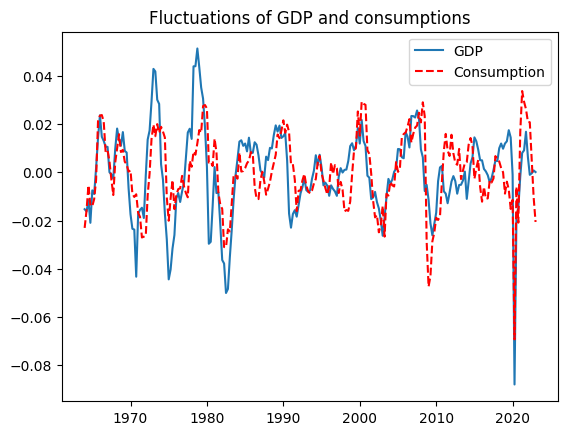

In [67]:
fig, ax = plt.subplots()

ax.plot(cycle_df.index, cycle_df.GDP, label = 'GDP')
ax.plot(cycle_df.index, cycle_df.CND, 'r--', label = 'Consumption')
ax.legend()

plt.title('Fluctuations of GDP and consumptions')

plt.savefig('images/cnd_gdp.jpg', dpi = 300)

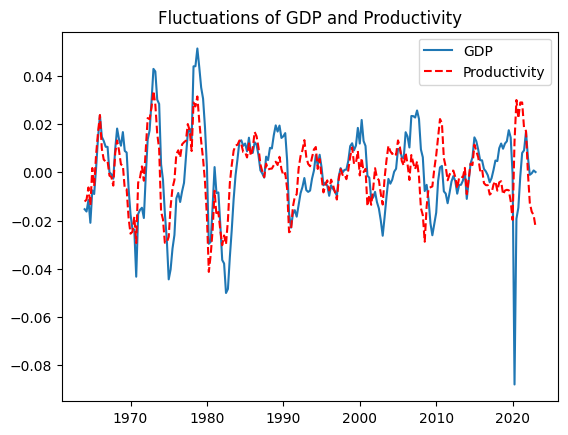

In [68]:
fig, ax = plt.subplots()

ax.plot(cycle_df.index, cycle_df.GDP, label = 'GDP')
ax.plot(cycle_df.index, cycle_df.Productivity, 'r--', label = 'Productivity')
ax.legend()

plt.title('Fluctuations of GDP and Productivity')

plt.savefig('images/productivity_gdp.jpg', dpi = 300)

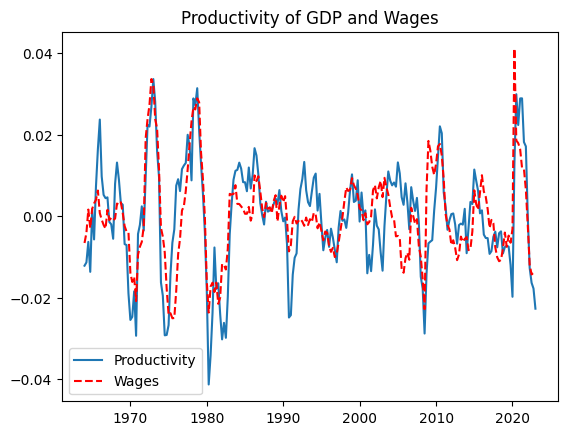

In [69]:
fig, ax = plt.subplots()

ax.plot(cycle_df.index, cycle_df.Productivity, label = 'Productivity')
ax.plot(cycle_df.index, cycle_df.Avg_Wage, 'r--', label = 'Wages')
ax.legend()

plt.title('Fluctuations of Productivity and Wages')

plt.savefig('images/wages_gdp.jpg', dpi = 300)

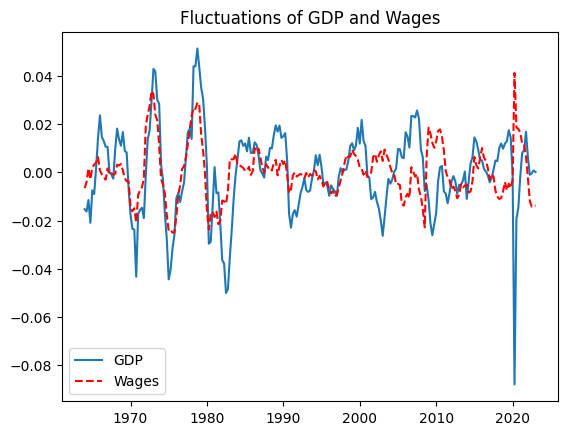

In [70]:
fig, ax = plt.subplots()

ax.plot(cycle_df.index, cycle_df.GDP, label = 'GDP')
ax.plot(cycle_df.index, cycle_df.Avg_Wage, 'r--', label = 'Wages')
ax.legend()

plt.title('Fluctuations of GDP and Wages')

plt.savefig('images/wages_gdp.jpg', dpi = 300)

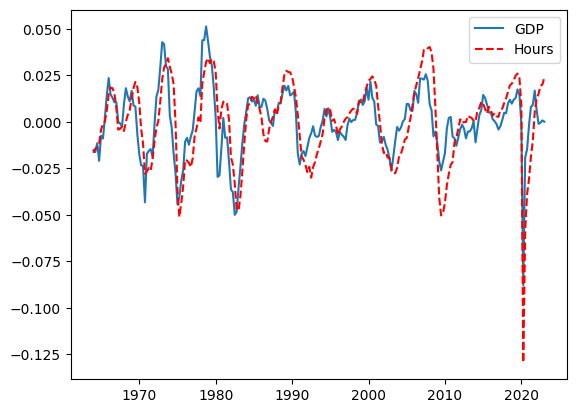

In [52]:
fig, ax = plt.subplots()

ax.plot(cycle_df.index, cycle_df.GDP, label = 'GDP')
ax.plot(cycle_df.index, cycle_df.Hours_worked, 'r--', label = 'Hours')
ax.legend()

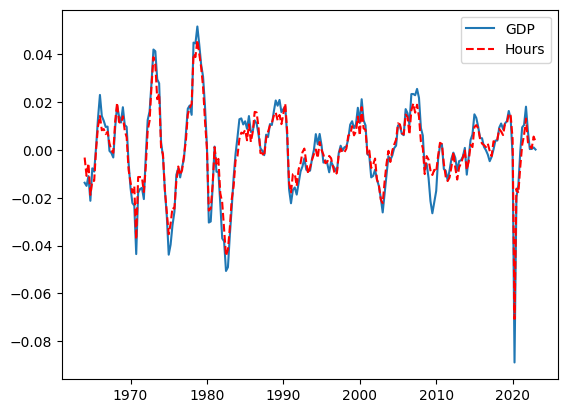

In [73]:
fig, ax = plt.subplots()

ax.plot(cycle_df_2.index, cycle_df_2.Y, label = 'GDP')
ax.plot(cycle_df_2.index, cycle_df_2['Y/N'], 'r--', label = 'Hours')
ax.legend()